In [1]:
import os
import matplotlib.pyplot as plt

from sda.mcs import *
from sda.score import *
from sda.utils import *

from experiments.kolmogorov.utils import *
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from netCDF4 import Dataset as NetCDFDataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

OBS_FNS = {
        'linear': lambda x: x,
        'arctan': lambda x: torch.arctan(x),
        'arctan15': lambda x: 15*torch.arctan(x),
        'arctan_scaled': lambda x: 15*torch.arctan(x/7),
        'abs': lambda x: torch.abs(x),
        'square': lambda x: torch.square(x),
        'square_scaled': lambda x: torch.square(x/7),
        'exp': lambda x: torch.exp(x),
        'exp_scaled': lambda x: torch.exp(x/7),
        'log_abs_scaled': lambda x: 6*torch.log(torch.abs(x)+0.1),
        'sin': lambda x: torch.sin(x),
        'sin_scaled': lambda x: 20*torch.sin(x/3),
    }


Using device: cuda


In [2]:
class TrajectoryDataset(Dataset):
    def __init__(
        self,
        file: Path,
        window: int = None,
        flatten: bool = False,
        normalize: float = True,
        mean: float = None,
        std: float = None
    ):
        super().__init__()

        with h5py.File(file, mode='r') as f:
            self.data = f['x'][:]

        self.window = window
        self.flatten = flatten
        self.normalize = normalize
        self.mean = self.data.mean() if mean is None else mean
        self.std = self.data.std() if mean is None else std

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, i: int) -> Tuple[Tensor, Dict]:
        x = torch.from_numpy(self.data[i])

        if self.normalize:
            x = (x - self.mean) / self.std

        if self.window is not None:
            i = torch.randint(0, len(x) - self.window + 1, size=())
            x = torch.narrow(x, dim=0, start=i, length=self.window)

        if self.flatten:
            return x.flatten(0, 1), {}
        else:
            return x, {}

In [3]:
window = 5

CONFIG = {
    # Architecture
    'window': window,
    'embedding': 64,
    'hidden_channels': (96, 192, 384),
    'hidden_blocks': (3, 3, 3),
    'kernel_size': 3,
    'activation': 'SiLU',
    # Training
    'epochs': 1000,
    'batch_size': 32,
    'optimizer': 'AdamW',
    'learning_rate': 2e-4,
    'weight_decay': 1e-3,
    'scheduler': 'cosine',
}

In [4]:
out_root = Path("./runs_sqg")      # output root (you can change)
out_root.mkdir(parents=True, exist_ok=True)

exp_name = f"mcscore_vpsde_sqg_window_{window}"
run_dir  = out_root / exp_name
ckpt_dir = run_dir / "checkpoints"
fig_dir  = run_dir / "figures"
hist_dir = run_dir / "history"

score = make_score(**CONFIG)
sde = VPSDE(score.kernel, shape=(CONFIG['window']*2, 64, 64))
sde = sde.to(device)

files = sorted(ckpt_dir.glob("epoch_*.pt"))
path = files[-1]
payload = torch.load(path, map_location=device)
score.load_state_dict(payload["score_state"])
sde.load_state_dict(payload["sde_state"])

<All keys matched successfully>

In [5]:
nx = 64
ny = 64

ARGS = {
    # Guidance
    'obs_type': 'random', # 'grid' or 'random'
    'obs_stride': 4, # applicable for obs_type=grid
    'obs_pct': 0.25, # observation percentage (applicable for obs_type=random)
    'obs_fn': 'square_scaled',
    'obs_sigma': 1.0,
    'n_ens': 20,
    'assim_window': 100,
    'guidance_method': 'dps'
}

if ARGS['obs_type'] == 'grid':
    stride = int(ARGS.get('obs_stride', 4))
    grid2d = torch.zeros(nx, ny, device=device)
    grid2d[::stride, ::stride] = 1.0
    obs_mask = grid2d.flatten()
    obs_mask = obs_mask.unsqueeze(0).view(1, nx, ny)
elif ARGS['obs_type'] == 'random':
    rsobs = np.random.RandomState(42) # fixed seed for observations
    nobs = int(nx*ny*ARGS['obs_pct'])
    indxob = np.sort(rsobs.choice(nx*ny, nobs, replace=False))
    
    sparse_index = torch.zeros(nx*ny, dtype=torch.bool, device=device)
    sparse_index[indxob] = True
    
    obs_mask = torch.ones(1, nx*ny, device=device)
    obs_mask[:, ~sparse_index] = 0
    obs_mask = obs_mask.view((nx, ny))
else:
    raise NotImplementedError

# if ARGS['obs_fn'] == 'linear':
#     obs_fn = lambda x: x
# elif ARGS['obs_fn'] == 'arctan':
#     obs_fn = lambda x: torch.atan(x)
# else:
#     raise NotImplementedError

obs_fn = OBS_FNS[ARGS['obs_fn']]


In [6]:
cond_window = 6

def A(x):
    return obs_fn(x) * obs_mask

test_dir = "/resnick/groups/astuart/sotakao/score-based-ensemble-filter/EnSFInpainting/data/test/"
fname = "sqg_N64_3hrly_100.nc"

nc_truth = NetCDFDataset(os.path.join(test_dir, fname), 'r')
pv_truth_nc = nc_truth.variables['pv']  # (T, 2, ny, nx)
T, Z, ny, nx = pv_truth_nc.shape
pv_truth = torch.tensor(np.array(pv_truth_nc[:min(T, cond_window), ...]), dtype=torch.float32, device=device)
scalefact = nc_truth.f * nc_truth.theta0 / nc_truth.g
nc_truth.close()

In [7]:
train_std = 2672.232
scale = train_std * scalefact

In [8]:
noise = torch.randn_like(pv_truth) * ARGS['obs_sigma']
y = scalefact*pv_truth*obs_mask.unsqueeze(0) + noise*obs_mask.unsqueeze(0)

In [9]:
score_scaled = lambda x, t, c: score(x/scale, t, c)

if ARGS['guidance_method'] == 'dps':
    guided_sde = ScaledVPSDE(
                    DPSGaussianScore(
                        y,
                        A=A,
                        std=ARGS['obs_sigma'],
                        sde=ScaledVPSDE(score_scaled, shape=(), scale=scale),
                        gamma=1e-2,
                        guidance_strength=0.2,
                        scale=False,
                    ),
                    shape=y.shape,
                    scale=scale,
                ).cuda()
elif ARGS['guidance_method'] == 'mmps':
    guided_sde = ScaledVPSDE(
                    MMPSGaussianScore(
                        y,
                        observation_fn=A,
                        std=ARGS['obs_sigma'],
                        sde=ScaledVPSDE(score_scaled, shape=(), scale=scale),
                        guidance_strength=0.01,
                        solver='gmres',
                        iterations=1,
                    ),
                    shape=y.shape,
                    scale=scale,
                ).cuda()

posterior_samples = guided_sde.sample((ARGS['n_ens'],),
                                      steps=100,
                                      corrections=1,
                                      tau=0.5).cpu()

100%|█████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


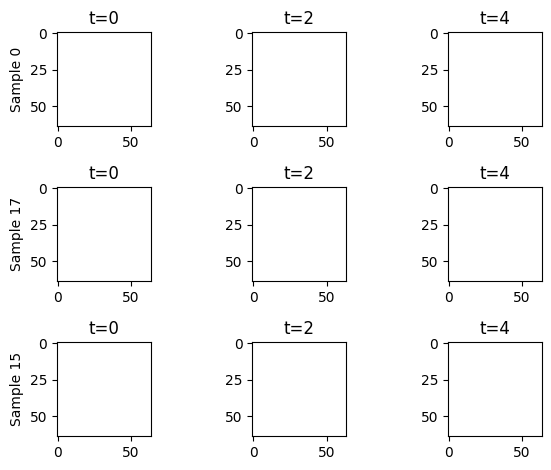

In [10]:
rng = np.random.RandomState(42)
idxs = rng.choice(ARGS['n_ens'], 3, replace=False)

fig, axs = plt.subplots(3,3)
for i in range(3):
    axs[i,0].imshow(posterior_samples[idxs[i],0,0], vmin=scalefact*pv_truth.min(), vmax=scalefact*pv_truth.max())
    axs[i,0].set_title("t=0")
    axs[i,0].set_ylabel(f"Sample {idxs[i]}")
    axs[i,1].imshow(posterior_samples[idxs[i],2,0], vmin=scalefact*pv_truth.min(), vmax=scalefact*pv_truth.max())
    axs[i,1].set_title("t=2")
    axs[i,2].imshow(posterior_samples[idxs[i],4,0], vmin=scalefact*pv_truth.min(), vmax=scalefact*pv_truth.max())
    axs[i,2].set_title("t=4")

plt.tight_layout()

In [11]:
x_star = scalefact * pv_truth
x_star = x_star.unsqueeze(0)
err = x_star.cpu() - posterior_samples
rmse = torch.mean(err**2)
print(f"rmse = {rmse:.3f}")

rmse = nan


In [164]:
save_dir = "/resnick/groups/astuart/sotakao/score-based-ensemble-filter/FlowDAS/experiments/sqg/data"
fname = f"inital_ensembles_{ARGS['obs_fn']}_{ARGS['obs_sigma']}_{ARGS['obs_pct']}pct"
torch.save(posterior_samples, os.path.join(save_dir, fname))